In [8]:
import pandas as pd
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import os
from common import data_folder_path
import matplotlib.pyplot as plt
import numpy as np


In [9]:
data_file = 'train.csv'
df = pd.read_csv(os.path.join(data_folder_path,data_file))
df['datetime'] = pd.to_datetime(df['datetime'])
df['Time of Day']=df['datetime'].dt.hour
df['Day of Week']=df['datetime'].dt.day_of_week
df

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,Time of Day,Day of Week
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,0,2
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,0,2
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,0,2
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,0,2
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,23,2
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,23,2
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,23,2
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,23,2


In [10]:
#based on this https://seasonsyear.com/Estonia
def get_season(row):
    month = row.month
    if month in [12,1,2,3]: #'Snow starts to fall at around middle of December and remains to mid-March. By the beginning of December temperature of water finally drops below zero (0C) thus the ice begins to appear by the coasts.'
        return 'Winter'
    elif month in [4,5]:
        return 'Spring'
    elif month in [6,7,8]:
        return 'Summer' #'Climate of the summer months: ... June ... July ... August'
    else:
        return 'Autumn' #'In Estonia coming of actual Autumn is almost simultaneous to calendar change of seasons.'

df['Season'] = df['datetime'].apply(get_season)
df['Season'].value_counts()#.plot(kind='bar')
assert df['Season'].value_counts().sum()==df.shape[0] #sanity check that all rows have a season

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
results_dict = {}
coefs_dict = {}
y_preds = {}
y_tests = {}
for is_consumption in [0,1]:
    #print('is_consumption',is_consumption)
    results_dict[is_consumption] = {}
    coefs_dict[is_consumption] = {}
    y_preds[is_consumption] = {}
    y_tests[is_consumption] = {}
    for is_business in [0,1]:
        results_dict[is_consumption][is_business] = {}
        coefs_dict[is_consumption][is_business] = {}
        y_preds[is_consumption][is_business] = {}
        y_tests[is_consumption][is_business] = {}
        for product_type in df['product_type'].unique():
            #print('product_type',product_type)
            train_cols = ['county','Time of Day','Day of Week', 'Season','target']
            train_data = df[(df['is_consumption']==is_consumption)&
                            (df['product_type']==product_type)&(df['is_business']==is_business)][train_cols].dropna()
            X,y = train_data.iloc[:,:-1],train_data.iloc[:,-1]
            if X.shape[0]==0:
                print('no data for is_consumption',is_consumption,'is_business',is_business,'product_type',product_type)
                continue
            y_ss = StandardScaler()
            y = y_ss.fit_transform(y.values.reshape(-1,1)).flatten()
            #y=y[np.isnan(y)]
            seasons = X['Season'].astype('category')
            X['Season'] = seasons.cat.codes

            county_onehot = pd.get_dummies(X['county'],prefix='county')
            X = X.join(county_onehot)

            dow_onehot = pd.get_dummies(X['Day of Week'],prefix='dow')
            X = X.join(dow_onehot)

            hour_onehot = pd.get_dummies(X['Time of Day'],prefix='hour')
            X = X.join(hour_onehot)
            X = X.drop(columns=['county','Day of Week','Time of Day'])

            X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
            lr = LinearRegression()
            lr.fit(X_train,y_train)
            y_pred = lr.predict(X_test)
            
            y_test = y_ss.inverse_transform(y_test.reshape(-1, 1))
            y_pred = y_ss.inverse_transform(y_pred.reshape(-1, 1))
            mae = mean_absolute_error(y_test,y_pred)
            coefs = list(zip(lr.coef_,lr.feature_names_in_))
            coefs_dict[is_consumption][is_business][product_type] = coefs
            results_dict[is_consumption][is_business][product_type] = mae
            y_preds[is_consumption][is_business][product_type] = y_pred
            y_tests[is_consumption][is_business][product_type] = y_test
            #print('\n'.join(map(str,)))
#print a grid of is_consumption columns and product_type rows
for is_consumption in [0,1]:
    for is_business in [0,1]:
        results_df = pd.DataFrame.from_dict(results_dict[is_consumption][is_business],orient='index')
        print('is_consumption',is_consumption,'is_business',is_business)
        print(results_df)
# print(coefs_dict[0][3])
# print(coefs_dict[1][3])
#results_df
#better at prediction production than consumption (because consumption is smooth)
#best at product 2 (8/25), followed by 1 (61/135) and 0 (55/254); 3 is bad (227/863)

no data for is_consumption 0 is_business 0 product_type 0
no data for is_consumption 1 is_business 0 product_type 0
is_consumption 0 is_business 0
            0
1   65.927174
2    6.261795
3  231.298875
is_consumption 0 is_business 1
            0
1   50.200150
2    8.215803
3  200.601653
0   50.467599
is_consumption 1 is_business 0
            0
1   39.700938
2    7.139319
3  117.357028
is_consumption 1 is_business 1
            0
1   98.530244
2   42.222084
3  412.762529
0  238.618510


In [12]:

print(df['product_type'].value_counts(),end='\n\n')
print("product type 3:",df[df['product_type']==3]['is_business'].value_counts())
#3 is the most common product type - have the most to gain from better prediction
#the high coef for is_business on product 3 combined with the poor predictions implies 
#there is some instrumentality/overloading of the is_business flag - what is that?



product_type
3    918720
1    781632
0    170544
2    147456
Name: count, dtype: int64

product type 3: is_business
1    489984
0    428736
Name: count, dtype: int64


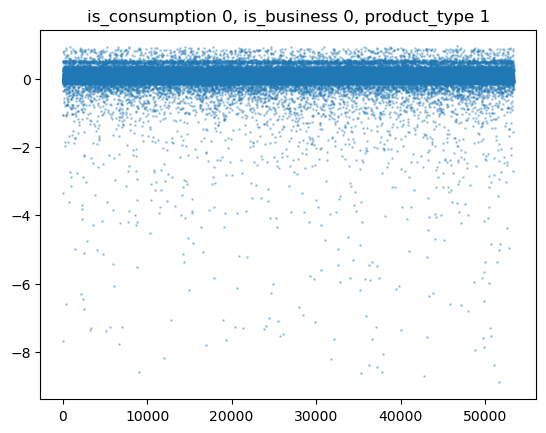

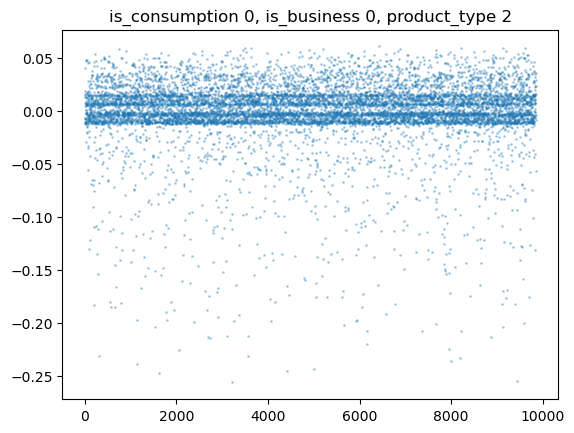

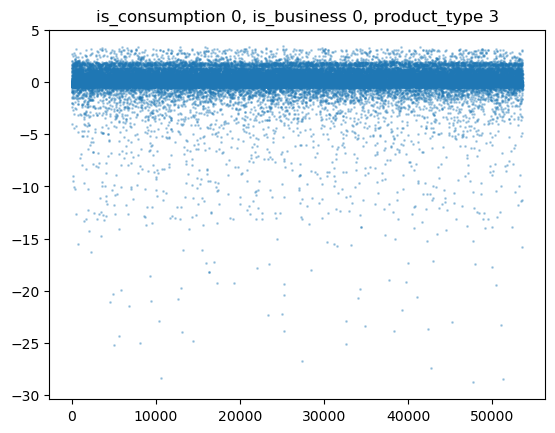

KeyError: 0

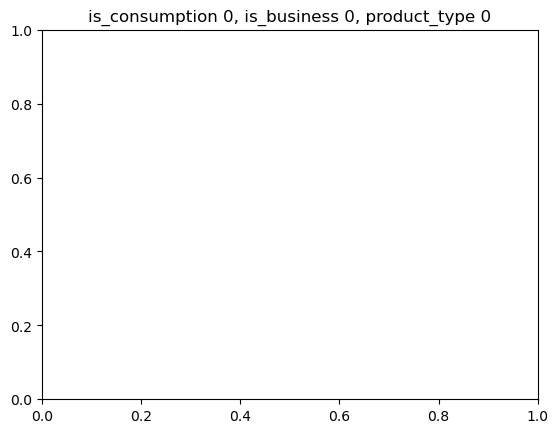

In [13]:
#show a chart of the error of each prediction, bucketed intelligently
for is_consumption in [0,1]:
    for is_business in [0,1]:
        for product_type in df['product_type'].unique():
            plt.figure()
            plt.title('is_consumption {}, is_business {}, product_type {}'.format(is_consumption,is_business,product_type))
            plt.scatter(x=range(len(y_preds[is_consumption][is_business][product_type])),y=y_ss.transform(y_preds[is_consumption][is_business][product_type])-y_ss.transform(y_tests[is_consumption][is_business][product_type]),s=1,marker='o',alpha=0.3)
            plt.show()
#plt.scatter(x=range(len(y_preds[1][3])),y=y_ss.transform(y_preds[1][3])-y_ss.transform(y_tests[1][3]),s=1,marker='o',alpha=0.3)

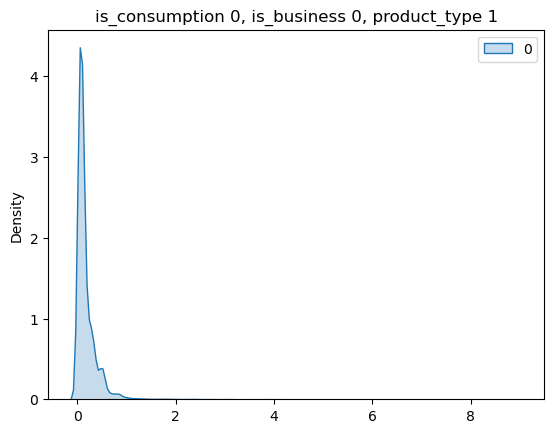

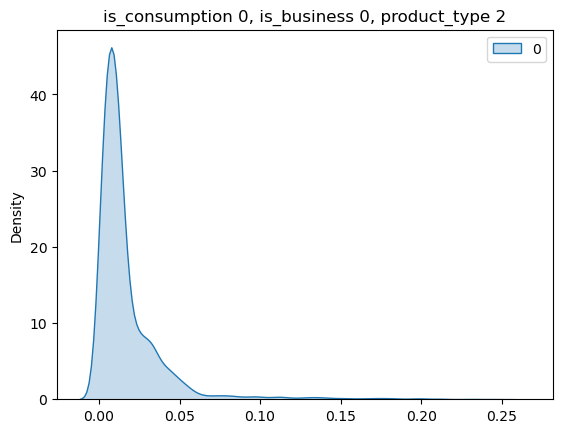

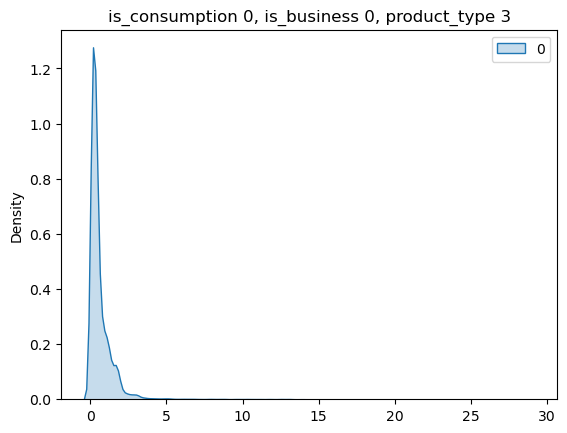

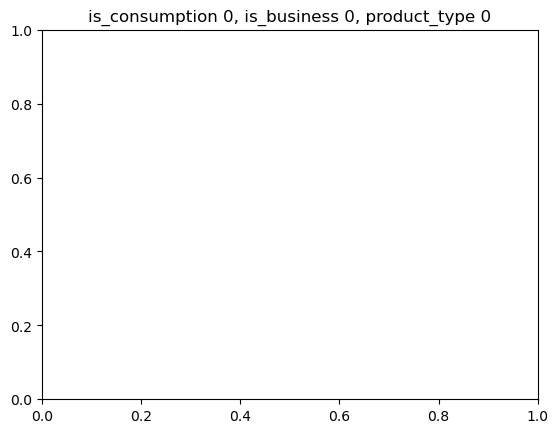

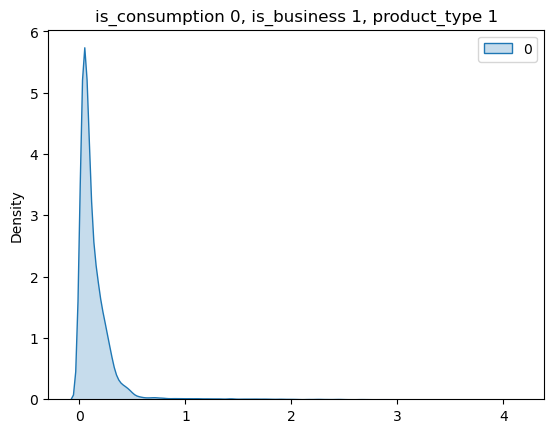

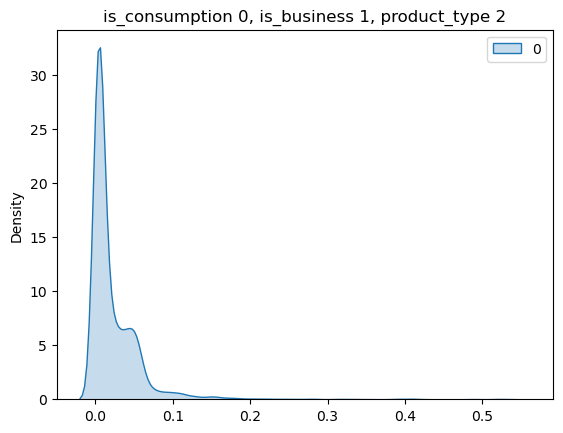

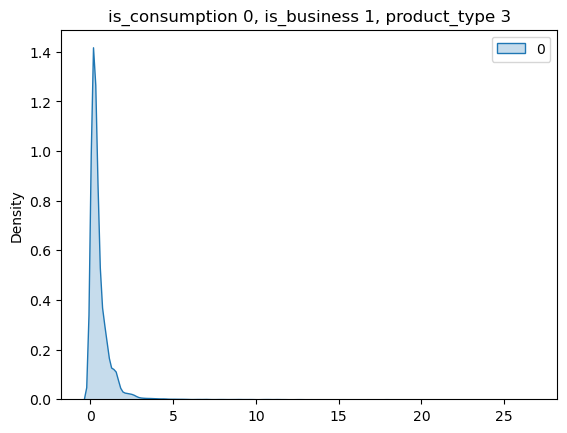

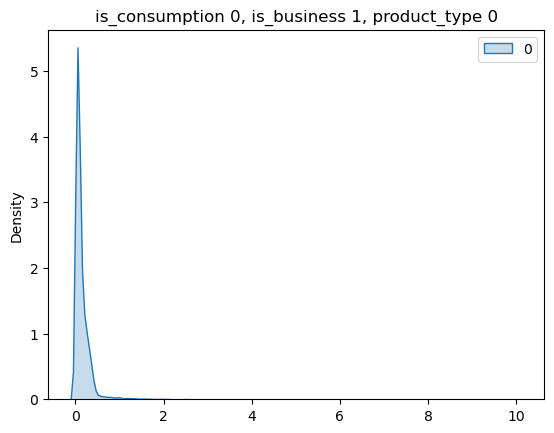

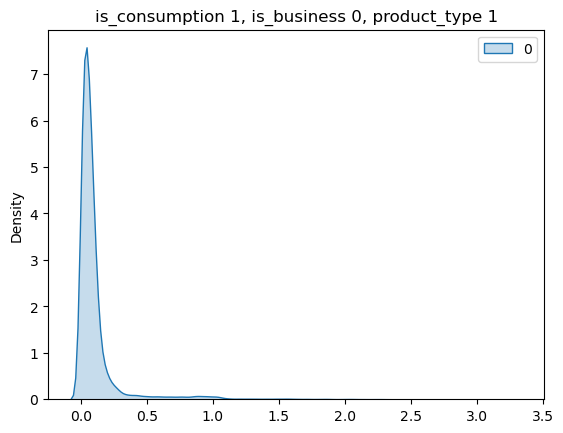

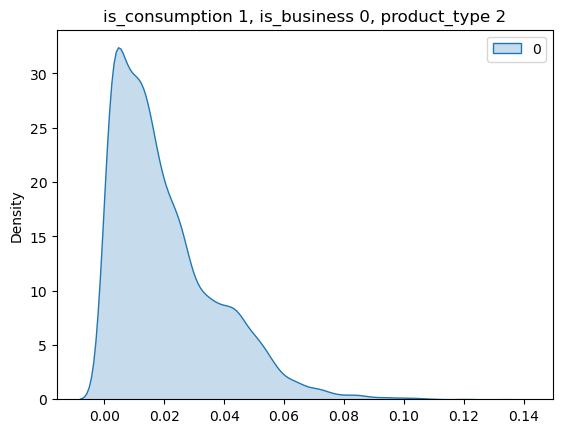

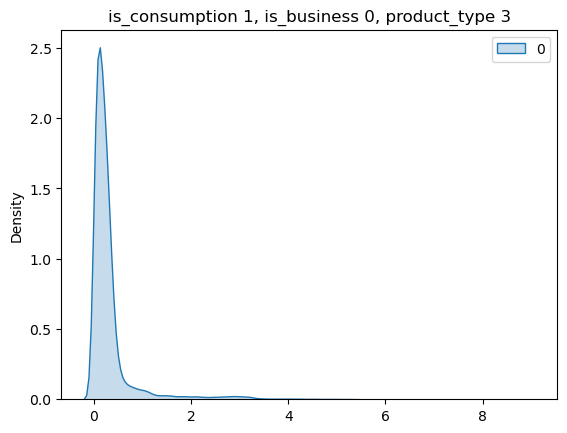

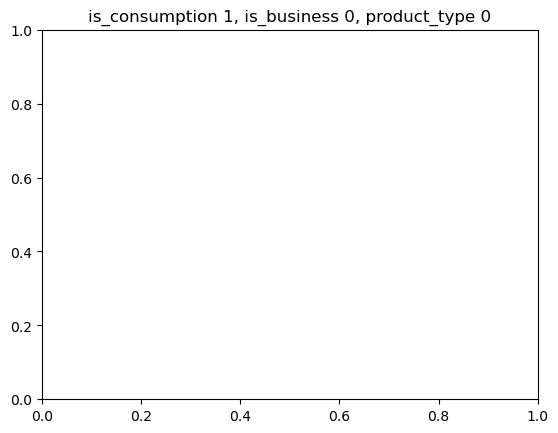

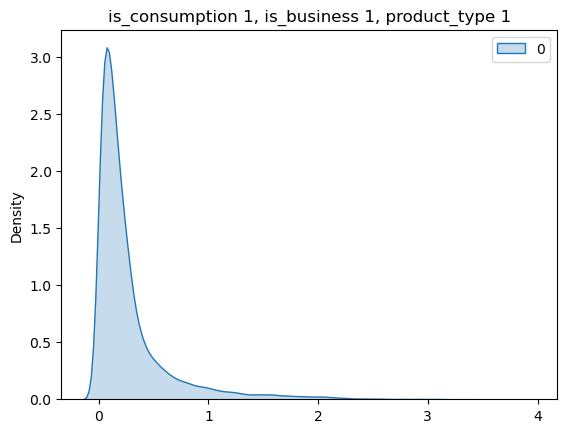

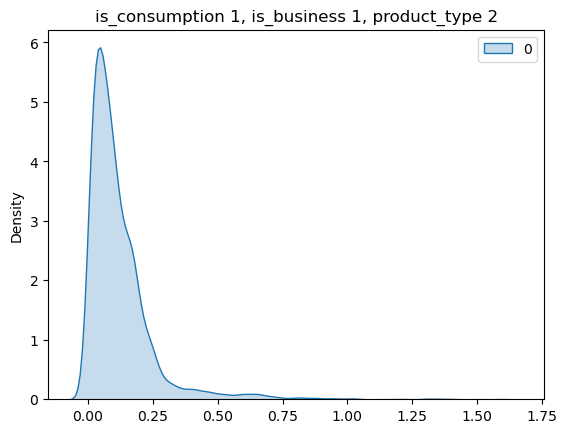

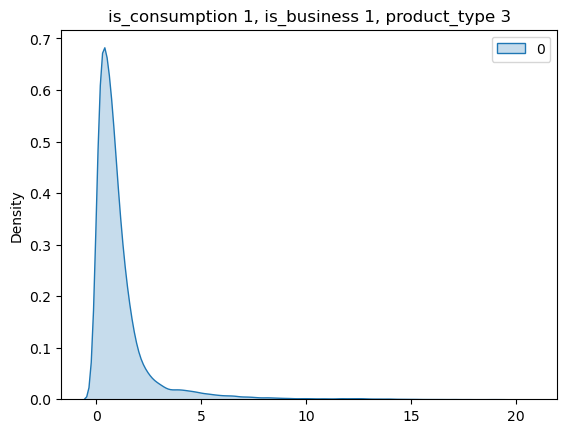

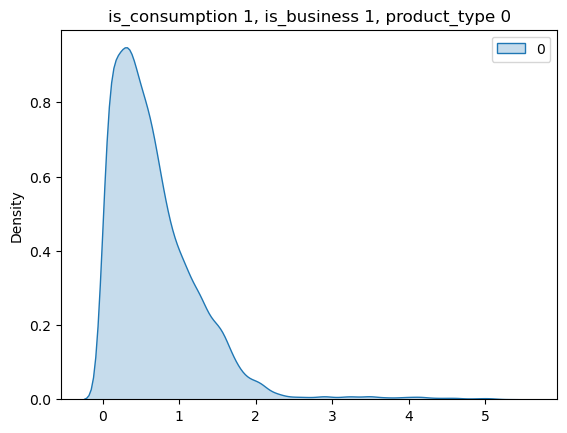

In [ ]:
#plot kde of errors
import seaborn as sns
for is_consumption in [0,1]:
    for is_business in [0,1]:
        for product_type in df['product_type'].unique():
            try:
                plt.figure()
                plt.title('is_consumption {}, is_business {}, product_type {}'.format(is_consumption,is_business,product_type))
                sns.kdeplot(np.abs(y_ss.transform(y_preds[is_consumption][is_business][product_type])-y_ss.transform(y_tests[is_consumption][is_business][product_type])),fill=True)
                plt.show()
            except:
                pass
#sns.kdeplot(y_ss.transform(y_preds[1][3])-y_ss.transform(y_tests[1][3]),shade=True)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   2.,   3.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   3.,   1.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   2.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   1.,   1.,   1.,
          1.,   0.,   0.,   1.,   1.,   0.,   0.,   2.,   1.,   0.,   1.,
          0.,   2.,   1.,   0.,   1.,   0.,   1.,   0.,   1.,   0.,   0.,
          0.,   1.,   1.,   1.,   1.,   0.,   3.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   1.,   1.,   0.,   2.,   0.,   1.,   0.,   0.,
          1.,   1.,   1.,   1.,   1., 

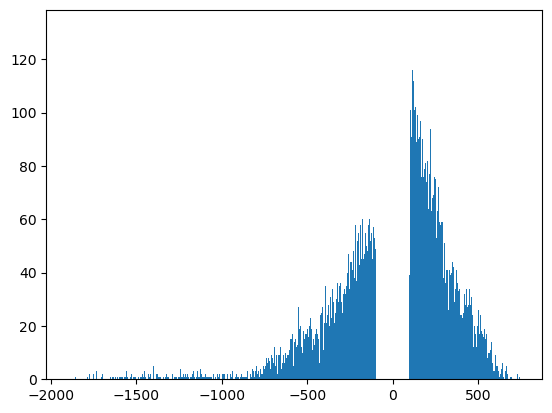

In [ ]:
eps = 100
plt.hist((y_pred-y_test)[np.abs(y_pred-y_test)>eps],bins=1000)

In [16]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
df['Month'] = df.datetime.dt.month
train_cols = ['county','is_business','product_type','is_consumption','Time of Day', 'Day of Week','Season', 'Month','target']
train_data = df[train_cols].dropna()
X,y = train_data.iloc[:,:-1],train_data.iloc[:,-1]

seasons = X['Season'].astype('category')
X['Season'] = seasons.cat.codes

county_onehot = pd.get_dummies(X['county'],prefix='county')
X = X.join(county_onehot)

dow_onehot = pd.get_dummies(X['Day of Week'],prefix='dow')
X = X.join(dow_onehot)

hour_onehot = pd.get_dummies(X['Time of Day'],prefix='hour')
X = X.join(hour_onehot)

product_type_onehot = pd.get_dummies(X['product_type'],prefix='product_type')
X = X.join(product_type_onehot)

X = X.drop(columns=['county','Day of Week','Time of Day','product_type'])

y_ss = StandardScaler()
y = y_ss.fit_transform(y.values.reshape(-1,1)).flatten()
y[np.isnan(y)]

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
from sklearn.metrics import mean_absolute_error

y_test = y_ss.inverse_transform(y_test.reshape(-1, 1))
y_pred = y_ss.inverse_transform(y_pred.reshape(-1, 1))
print('MAE: ',mean_absolute_error(y_test,y_pred))
print('\n'.join(map(str,list(zip(lr.coef_,lr.feature_names_in_)))))


MAE:  380.3624348013341
(0.33951646514059436, 'is_business')
(0.4084465917883985, 'is_consumption')
(0.006912131672160031, 'Season')
(-0.003724435950466176, 'Month')
(2586003064.0280056, 'county_0')
(2586003062.726372, 'county_1')
(2586003062.838586, 'county_2')
(2586003062.883027, 'county_3')
(2586003062.922929, 'county_4')
(2586003063.014015, 'county_5')
(2586003062.4049892, 'county_6')
(2586003063.102276, 'county_7')
(2586003062.7810225, 'county_8')
(2586003062.8035264, 'county_9')
(2586003062.983473, 'county_10')
(2586003063.546768, 'county_11')
(2586003062.6083364, 'county_12')
(2586003062.8139987, 'county_13')
(2586003063.0170436, 'county_14')
(2586003062.8869886, 'county_15')
(-135400372.39230978, 'dow_0')
(-135400372.38780832, 'dow_1')
(-135400372.38410896, 'dow_2')
(-135400372.3890358, 'dow_3')
(-135400372.39254558, 'dow_4')
(-135400372.44475338, 'dow_5')
(-135400372.44927654, 'dow_6')
(-18935550.50044854, 'hour_0')
(-18935550.504477166, 'hour_1')
(-18935550.504324574, 'hour_2

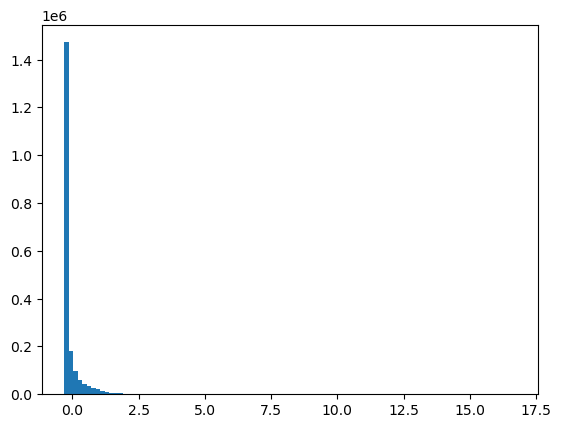

100%|██████████| 59/59 [00:07<00:00,  8.09it/s]


splitting dataset...
training regression...


(427.86175647447055,
 384.94704365586017,
 [(-9033245381.704042, 'producing_business'),
  (-9033245380.945852, 'consuming_business'),
  (-9033245381.706112, 'producing_nonbusiness'),
  (-9033245381.674961, 'consuming_nonbusiness'),
  (-15845755145594.21, 'season_Autumn'),
  (-15845755145594.082, 'season_Spring'),
  (-15845755145594.16, 'season_Summer'),
  (-15845755145594.113, 'season_Winter'),
  (1438869649162.7292, 'county_0'),
  (1438869649161.3887, 'county_1'),
  (1438869649161.4805, 'county_2'),
  (1438869649161.5283, 'county_3'),
  (1438869649161.5537, 'county_4'),
  (1438869649161.67, 'county_5'),
  (1438869649161.1074, 'county_6'),
  (1438869649161.755, 'county_7'),
  (1438869649161.4727, 'county_8'),
  (1438869649161.4756, 'county_9'),
  (1438869649161.6602, 'county_10'),
  (1438869649162.2183, 'county_11'),
  (1438869649161.2637, 'county_12'),
  (1438869649161.4727, 'county_13'),
  (1438869649161.6904, 'county_14'),
  (1438869649161.5547, 'county_15'),
  (2875492266822.231, '

In [29]:
#print('product_type',product_type)
train_cols = ['county','Time of Day','Day of Week', 'Season','is_business','is_consumption','product_type','target']
train_data = df[train_cols].dropna()

X,y = train_data.iloc[:,:-1],train_data.iloc[:,-1]
#print(X,y)
y_ss = StandardScaler()
y = y_ss.fit_transform(y.values.reshape(-1,1)).flatten()

plt.hist(y,bins=100)
plt.show()
# seasons = X['Season'].astype('category')
# X['Season'] = seasons.cat.codes

X['producing_business'] = X['is_business'] & ~X['is_consumption']
X['consuming_business'] = X['is_business'] & X['is_consumption']
X['producing_nonbusiness'] = ~X['is_business'] & ~X['is_consumption']
X['consuming_nonbusiness'] = ~X['is_business'] & X['is_consumption']

season_onehot = pd.get_dummies(X['Season'],prefix='season')
X = X.join(season_onehot)

county_onehot = pd.get_dummies(X['county'],prefix='county')
X = X.join(county_onehot)

dow_onehot = pd.get_dummies(X['Day of Week'],prefix='dow')
X = X.join(dow_onehot)

hour_onehot = pd.get_dummies(X['Time of Day'],prefix='hour')
X = X.join(hour_onehot)

product_type_onehot = pd.get_dummies(X['product_type'],prefix='product_type')
X = X.join(product_type_onehot)

X = X.drop(columns=['Season','county','Day of Week','Time of Day','product_type','is_business','is_consumption'])
#all iteractions of one hot variables
#avoid this error: C:\Users\Joe\AppData\Local\Temp\ipykernel_6352\3011464885.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
#  X[col+'_'+col2] = X[col]*X[col2]
from tqdm import tqdm
new_cols = {}

for col in tqdm(X.columns):
    if 'season' in col or 'county' in col or 'dow' in col or 'hour' in col: #or 'product_type' in col
        for col2 in X.columns:
            if 'season' in col2 or 'county' in col2 or 'dow' in col2 or 'hour' in col2: #or 'product_type' in col2
                if col2 != col:
                    if col+'_'+col2 not in new_cols and col2+'_'+col not in new_cols:
                    # Convert boolean values to integers before multiplying
                        new_cols[col+'_'+col2] = X[col].astype(int) * X[col2].astype(int)
# new_col_df = pd.DataFrame(new_cols)
# print(f'adding {new_col_df.shape[1]} interactions to X')
# X = pd.concat([X, new_col_df], axis=1)
# del new_col_df



print('splitting dataset...')
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

print("training regression...")
lr = LinearRegression(n_jobs=-1)
lr.fit(X_train,y_train)

y_pred = lr.predict(X_test)
y_test = y_ss.inverse_transform(y_test.reshape(-1, 1))
y_pred = y_ss.inverse_transform(y_pred.reshape(-1, 1))

train_mae = mean_absolute_error(y_train,y_ss.inverse_transform(lr.predict(X_train).reshape(-1, 1)))
test_mae = mean_absolute_error(y_test,y_pred)



coefs = list(zip(lr.coef_,lr.feature_names_in_))
train_mae,test_mae,coefs

In [23]:
#print('\n'.join(map(str,coefs)))

In [47]:
#print('product_type',product_type)
train_cols = ['product_type','Time of Day','target'] #'is_business','is_consumption',
train_data = df[train_cols].dropna()

X,y = train_data.iloc[:,:-1],train_data.iloc[:,-1]
#print(X,y)
y_ss = StandardScaler()
y = y_ss.fit_transform(y.values.reshape(-1,1)).flatten()

# tod_onehot = pd.get_dummies(X['Time of Day'],prefix='tod')
# X = X.join(tod_onehot)

# X = X.drop(columns=['Time of Day'])

#X = X.drop(columns=['Season','county','Day of Week','Time of Day','product_type','is_business','is_consumption'])

# seasons = X['Season'].astype('category')
# X['Season'] = seasons.cat.codes


print('splitting dataset...')
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

print("training regression...")
lr = LinearRegression(n_jobs=-1)
lr.fit(X_train,y_train)

y_pred = lr.predict(X_test)
y_test = y_ss.inverse_transform(y_test.reshape(-1, 1))
y_pred = y_ss.inverse_transform(y_pred.reshape(-1, 1))

train_mae = mean_absolute_error(y_train,y_ss.inverse_transform(lr.predict(X_train).reshape(-1, 1)))
test_mae = mean_absolute_error(y_test,y_pred)



coefs = list(zip(lr.coef_,lr.feature_names_in_))
train_mae,test_mae,coefs

splitting dataset...
training regression...


(275.76686149758217,
 366.4512322287389,
 [(0.1610775347399094, 'product_type'),
  (0.0025922230034516706, 'Time of Day')])